# Conser-vision Practice Area: Image Classification
#### HOSTED BY DRIVENDATA
In this notebook I'm going to explore and identify animal species in a real world dataset of wildlife images for [the Conser-vision competition on DrivenData](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/page/409/).

The goal is to classify animal species that appear in camera trap images collected at the [Tai National Park](https://en.wikipedia.org/wiki/Ta%C3%AF_National_Park) in Côte d'Ivoire. Camera traps are one of the best tools available to study and monitor wildlife populations, and the enormous amounts of data they provide can be used to track different species for conservation efforts - once they are processed.

## 1. Let's get started
First of all, we want to import useful packages and the csv files.

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

import matplotlib.image as mpimg

# plotting default settings for better images
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams['figure.dpi']= 300
plt.rcParams['xtick.direction']= 'out'

In [39]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

The `features` CSVs contain the image ID, filepath and site ID for each image. 

In [22]:
train_features.head(2)

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069


In [23]:
test_features.head(2)

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040


In [24]:
train_features.shape[0]

16488

The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [25]:
train_labels.head(3)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [26]:
species_labels = sorted(train_labels.columns)
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## 2 Exploratory Data Analysis
Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label.

In [63]:
random_state = 24

# grid with 8 positions, one for each label
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    print(img.shape,'ratio',img.shape[1]/img.shape[0])
    
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

Output hidden; open in https://colab.research.google.com to view.

### 2.1 Species distribution
Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [28]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [29]:
train_labels.sum().sort_values(ascending=False)/train_labels.shape[0]

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

### 2.2 Camera trap sites
Let's look at the distribution of camera trap sites:

In [74]:
count_sites = train_features.groupby('site').count().sort_values('filepath',ascending=False)
count_sites=count_sites.rename(columns={"filepath": "train_count"})
count_sites
test_sites=test_features.groupby('site').count().sort_values('filepath')
test_sites=test_sites.rename(columns={"filepath": "test_count"})
count_sites=count_sites.join(test_sites, how='outer')

print('Number of sites present in both training and test samples:')
count_sites.dropna(how='any').shape[0]

Number of sites present in both training and test samples:


0

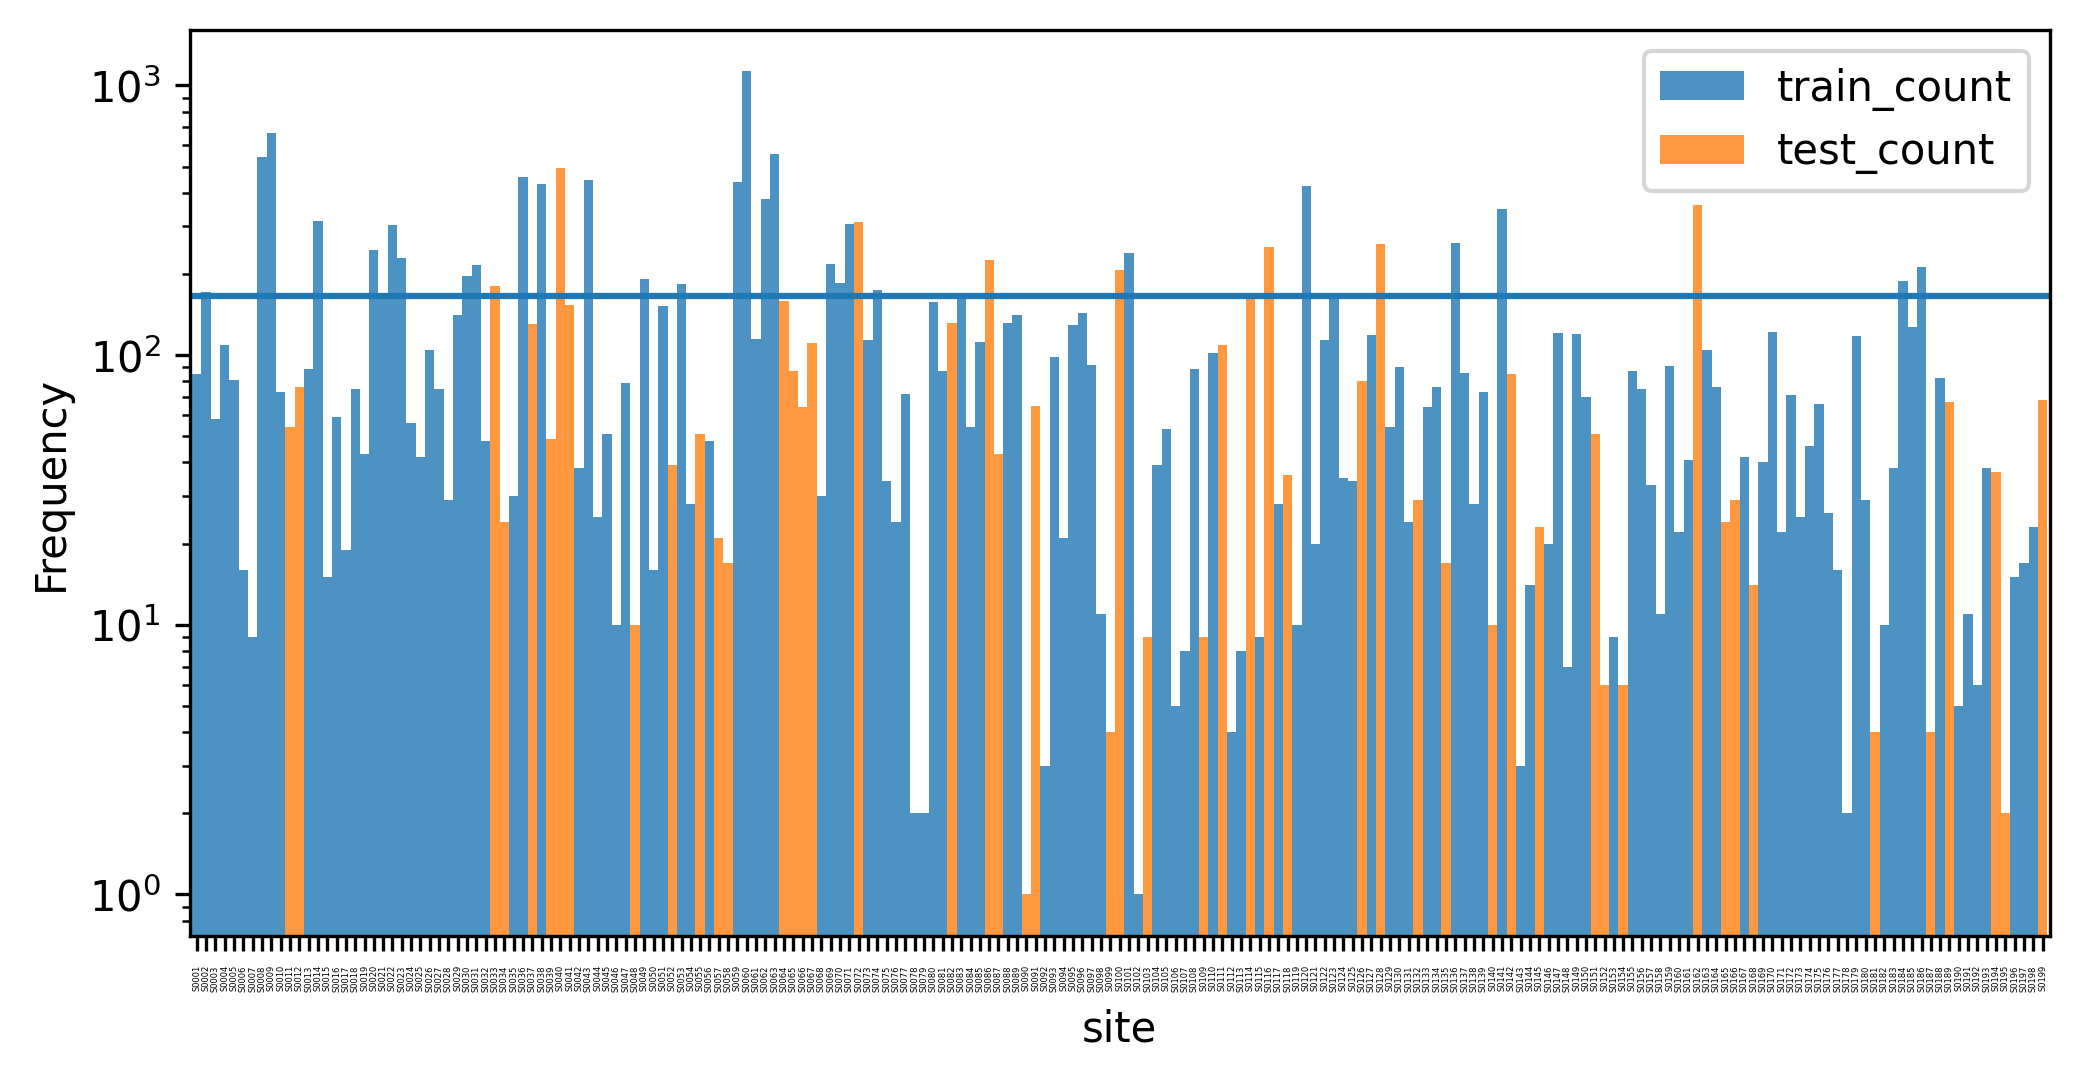

In [73]:
count_sites.plot.bar(stacked=True,width=1,alpha=.8)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xticks(fontsize=2)
plt.axhline(165)
plt.show()

In [ ]:
total_sites=train_features[['site']].nunique()[0]
low_repr_sites=count_sites.loc[count_sites.filepath<165].count()[0]
low_repr_sites/total_sites

0.8040540540540541

Most sites ($\sim 80\%$) have a small representation ($<1\% \simeq165$, see blue horizontal line on the histogram above) . Also, there is no match between the sites in the training sample and the test sample, which might make the test harder for the model.

### 2.3 Image size exploration
Let's go on to analyze the shapes of the images. We are interested in the pizel width and height, colors ("depth" of the image) and the ratio between height and width.

## Git commands
These are a few useful cells to push my work to my Github repository. As such, they are not part of the classification problem and are left here at the bottom of the notebook for practical reasons.

In [5]:
%ls

drive/  sample_data/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd 'drive/MyDrive/Conser-vision_Practice_Area_Image_Classification/competition_VfIpjyh'
%ls

/content/drive/MyDrive/Conser-vision_Practice_Area_Image_Classification/competition_VfIpjyh
benchmark.ipynb                     submission_format.csv  train_features.csv
Conser-vision_classification.ipynb  test_features/         train_labels.csv
LICENSE.md                          test_features.csv
README.md                           train_features/


In [9]:
!git config --global user.email "carrarorosamaria@gmail.com"
!git config --global user.name "RosCarraro"

In [65]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Conser-vision_classification.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	benchmark.ipynb
	submission_format.csv
	test_features.csv
	test_features/
	train_features.csv
	train_features/
	train_labels.csv

no changes added to commit (use "git add" and/or "git commit -a")


In [11]:
!git add Conser-vision_classification.ipynb

In [12]:
!git commit -m "Read data and started EDA"

[main 30ab7af] Read data and started EDA
 3 files changed, 26 insertions(+), 1 deletion(-)
 rewrite Conser-vision_classification.ipynb (87%)
 create mode 100644 LICENSE.md
 create mode 100644 README.md


In [17]:
!git push -u origin main


Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 759.17 KiB | 4.36 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 1 local object.
To https://github.com/RosCarraro/Conser-vision.git
   8796f6d..646581e  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In case there is the need to pull changes from the repository:

In [14]:
!git pull --rebase --autostash

Created autostash: e8d4f2d
HEAD is now at 30ab7af Read data and started EDA
First, rewinding head to replay your work on top of it...
Applying: Read data and started EDA
Applying: Read data and started EDA
Using index info to reconstruct a base tree...
Falling back to patching base and 3-way merge...
Applied autostash.
